In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("3_classes_processed_data.csv")

In [3]:
# Encode categorical variables
#label_encoders = {}
#for column in ['ductility']:
#    label_encoders[column] = LabelEncoder()
#    df[column] = label_encoders[column].fit_transform(df[column])
df.loc[df['ductility'] == 'pre_code','ductility']=0
df.loc[df['ductility'] == 'low_code','ductility']=1
df.loc[df['ductility'] == 'medium_code','ductility']=2
df.loc[df['ductility'] == 'high_code','ductility']=3
df['ductility'] = df['ductility'].astype(int)

df = pd.get_dummies(df, columns=['roof', 'relative_position'], drop_first=True)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [4]:
# Define features and target
X = df.drop(columns=['structural_system'])
y = df['structural_system']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8618618618618619
Classification Report:
              precision    recall  f1-score   support

          CR       0.89      0.61      0.72        56
           M       0.86      0.98      0.91       252
     M99/ADO       0.78      0.28      0.41        25

    accuracy                           0.86       333
   macro avg       0.84      0.62      0.68       333
weighted avg       0.86      0.86      0.84       333



# 1 - Class imbalance

## 1.1 - Oversampling (SMOTE)

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

**Class weights + SMOTE:**

In [12]:
# Initialize and train the Random Forest classifier with class weights + SMOTE
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_res, y_train_res)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8468468468468469
Classification Report:
              precision    recall  f1-score   support

          CR       0.76      0.66      0.70        56
           M       0.91      0.89      0.90       252
     M99/ADO       0.54      0.80      0.65        25

    accuracy                           0.85       333
   macro avg       0.74      0.78      0.75       333
weighted avg       0.86      0.85      0.85       333



**Only class weights:**

In [10]:
# Initialize and train the Random Forest classifier with class weights + SMOTE
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8588588588588588
Classification Report:
              precision    recall  f1-score   support

          CR       0.87      0.61      0.72        56
           M       0.87      0.96      0.91       252
     M99/ADO       0.65      0.44      0.52        25

    accuracy                           0.86       333
   macro avg       0.80      0.67      0.72       333
weighted avg       0.85      0.86      0.85       333



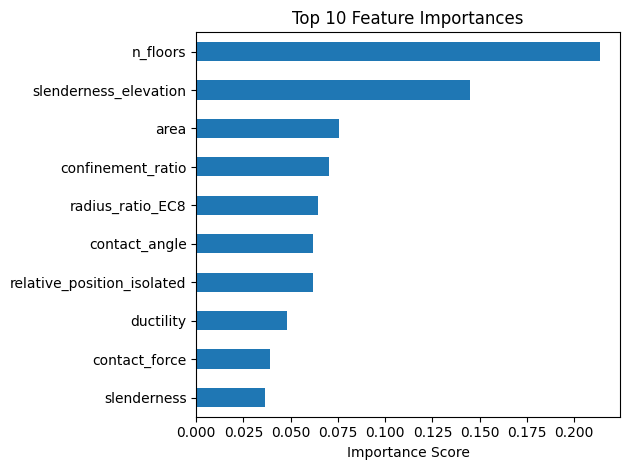

In [15]:
importances = rf_classifier.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a sorted plot
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

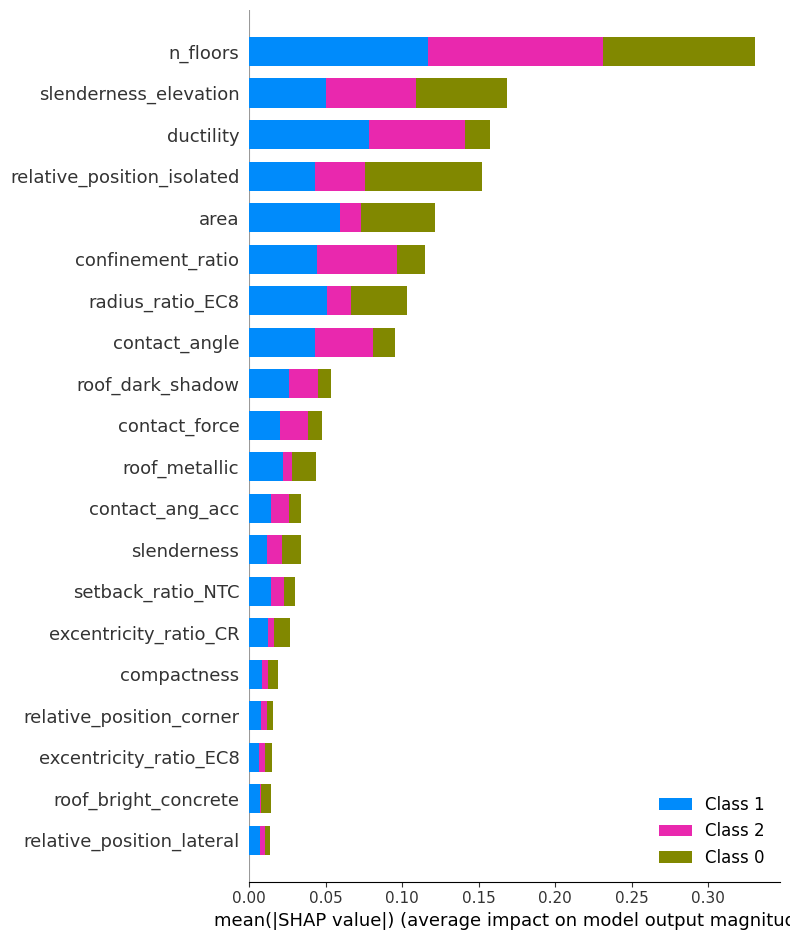

In [33]:
import shap

# Create the explainer
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)

# Summary plot for class 1 (for binary classification)
shap.summary_plot(shap_values, X_test, plot_type='bar')
#shap.summary_plot(shap_values, X_test)  # beeswarm plot